In [1]:
import sys
sys.path.append(r'../')
import numpy as np
from scipy import signal
import mat73
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

2022-08-10 17:41:17.583884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 17:41:17.583901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Database:
    def __init__(self):
        data_set_no = 0
        data_dict = mat73.loadmat('NoStim_Data.mat')
        data  = data_dict['NoStim_Data']

        deltaFOverF_bc = data['deltaFOverF_bc'][data_set_no]
        derivatives = data['derivs'][data_set_no]
        NeuronNames = data['NeuronNames'][data_set_no]
        fps = data['fps'][data_set_no]
        States = data['States'][data_set_no]


        self.states = np.sum([n*States[s] for n, s in enumerate(States)], axis = 0).astype(int) # making a single states array in which each number corresponds to a behaviour
        self.state_names = [*States.keys()]
        self.neuron_traces = np.array(deltaFOverF_bc).T
        self.derivative_traces = derivatives['traces'].T
        self.neuron_names = np.array(NeuronNames, dtype=object)
        self.fps = fps

def r2_single(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    return 1 - mse(y_pred, y_true)/tf.math.reduce_variance(y_true)

def r2(Y_true, Y_pred):
    r2_list=[]
    for i in range(Y_true.shape[-1]):
        R2 = r2_single(Y_true[:,i], Y_pred[:,i])
        r2_list.append(R2)
    r2_list = tf.stack(r2_list)
    return tf.math.reduce_mean(r2_list)

def bandpass(traces, f_l, f_h, sampling_freq):
    cut_off_h = f_h*sampling_freq/2 ## in units of sampling_freq/2
    cut_off_l= f_l*sampling_freq/2 ## in units of sampling_freq/2

    sos = signal.butter(4, [cut_off_l, cut_off_h], 'bandpass', fs=sampling_freq, output='sos')
    ### filtering the traces forward and backwards
    filtered = signal.sosfilt(sos, traces)
    filtered = np.flip(filtered, axis=1)
    filtered = signal.sosfilt(sos, filtered)
    filtered = np.flip(filtered, axis=1)
    return filtered

def hits_at_rank(rank, Y_test, Y_pred):
    nbrs = NearestNeighbors(n_neighbors=rank, algorithm='ball_tree').fit(Y_test)
    distances, indices = nbrs.kneighbors(Y_test)
    return np.mean(np.linalg.norm(Y_pred - Y_test, axis=1) < distances[:,-1])

In [3]:
data = Database()
X = data.neuron_traces.T
B = data.states
X = X[:,:100]

## Preprocessing the data

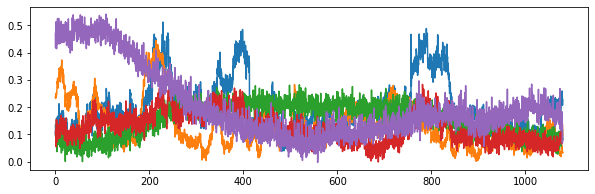

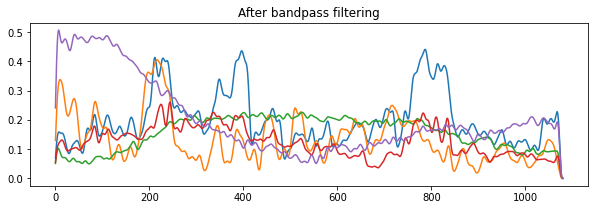

In [4]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.05, sampling_freq=data.fps).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')

plt.show()

In [5]:
X = filtered
np.arange(1,12,2)

array([ 1,  3,  5,  7,  9, 11])

### Predicting $\Delta X$  

In [17]:
# Preparing the data (Method new)
win = 15
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))
X_diff = np.zeros((X.shape[0]-win-gap, X.shape[1]))
X_t = np.zeros((X.shape[0]-win-gap, X.shape[1]))
for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]
    X_diff[i] = X[i+win+gap-1] - X[i+win-1]
    X_t[i] = X[i+win-1]

mse_list = []
baseline_list = []
# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_diff)):

    Xwin_train, Xwin_test = X_win[train_index], X_win[test_index]
    Xdiff_train, Xdiff_test = X_diff[train_index], X_diff[test_index]
    Xt_train, Xt_test = X_t[train_index], X_t[test_index]

    # Scaling the output
    Xdmax = (np.abs(Xdiff_train)).max() # Parameters for scaling

    Xdiff_train = Xdiff_train / Xdmax
    Xdiff_test = Xdiff_test / Xdmax

    # Defining the model
    model_2 = tf.keras.Sequential([
        #tf.keras.layers.Conv1D(filters=100,
        #                       kernel_size=(3,),
        #                       activation='relu', input_shape = (win,100,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(100, activation='linear')
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_2.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])

    history = model_2.fit(Xwin_train,
                          Xdiff_train,
                          epochs=80,
                          batch_size=50,
                          validation_data=(Xwin_test, Xdiff_test),
                          verbose=0
                          )

    # Summarize history for accuracy
    #plt.plot(history.history['mse'])
    #plt.plot(history.history['val_mse'])

    Xdiff_pred = model_2(Xwin_test).numpy()
    #plt.matshow(Xdiff_test.T, cmap="seismic", vmin=-1, vmax=1)
    #plt.matshow(Xdiff_pred.T, cmap="seismic", vmin=-1, vmax=1)
    #plt.matshow(Xdiff_pred.T- Xdiff_test.T, cmap="seismic", vmin=-1, vmax=1)
    #plt.show()

    ### Inverse transform for evaluation
    Xdiff_pred = Xdiff_pred*Xdmax 
    Xdiff_test = Xdiff_test*Xdmax

    Xt1_pred = Xt_test + Xdiff_pred
    Xt1_test = Xt_test + Xdiff_test

    mse = tf.keras.losses.MeanSquaredError()
    print('Baseline error', mse(Xt1_test, Xt_test).numpy().round(5), 'Mean square error:', mse(Xt1_test, Xt1_pred).numpy().round(5))
    baseline_list.append(mse(Xt1_test, Xt_test).numpy())
    mse_list.append(mse(Xt1_test, Xt1_pred).numpy())


Baseline error 8e-05 Mean square error: 4e-05
Baseline error 5e-05 Mean square error: 2e-05
Baseline error 5e-05 Mean square error: 1e-05
Baseline error 5e-05 Mean square error: 1e-05
Baseline error 2e-05 Mean square error: 1e-05
Baseline error 2e-05 Mean square error: 1e-05
Baseline error 3e-05 Mean square error: 1e-05


In [16]:
print(np.mean(baseline_list), 'pm', np.std(baseline_list))
print(np.mean(mse_list), 'pm', np.std(mse_list))


4.2191086330960857e-05 pm 1.9113335146804973e-05
2.192194658707223e-05 pm 1.6582343879639047e-05


In [8]:
hits_at_rank(2,Xt1_test, Xt1_pred)

0.6741573033707865

### Predicting $X_{t+1}$ directly 

In [9]:
# Preparing the data
win = 12
gap = 2
X_t1 = X[win:] 
X_t = X[win-gap:-gap]
X_win = np.zeros((X.shape[0]-win, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]


mse_list = []
# Train test split 
kf = KFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(X_t1)):

    Xwin_train, Xwin_test = X_win[train_index], X_win[test_index]
    X_t1_train, X_t1_test = X_t1[train_index], X_t1[test_index]
    Xt_train, Xt_test = X_t[train_index], X_t[test_index]

    # Scaling the output
    Xdmax = (np.abs(X_t1_train)).max() # Parameters for scaling

    X_t1_train = X_t1_train / Xdmax
    X_t1_test = X_t1_test / Xdmax

    # Defining the model
    model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=100,
                               kernel_size=(3,),
                               activation='relu', input_shape = (win,100,)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(100, activation='linear')
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_2.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mse'])

    history = model_2.fit(Xwin_train,
                          X_t1_train,
                          epochs=80,
                          batch_size=50,
                          validation_data=(Xwin_test, X_t1_test),
                          verbose=0
                          )


    # summarize history for accuracy
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    #plt.title('model mse')
    #plt.ylabel('mse')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    #plt.show()

    X_t1_pred = model_2(Xwin_test).numpy()

    ### Inverse transform for evaluation
    X_t1_pred = X_t1_pred*Xdmax 
    X_t1_test = X_t1_test*Xdmax


    mse = tf.keras.losses.MeanSquaredError()
    print('Baseline error', mse(X_t1_test, Xt_test).numpy().round(5), 'Mean square error:', mse(X_t1_test, X_t1_pred).numpy().round(5))
    plt.matshow(X_t1_test.T- X_t1_pred.T, cmap="seismic", vmin=-1, vmax=1)
    plt.show()
    mse_list.append(mse(X_t1_test, X_t1_pred).numpy())
    

mse_list

KeyboardInterrupt: 